<a href="https://colab.research.google.com/github/gigichen880/tsa_dsu_s2024/blob/main/autoreg_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/WTI_Minute_Data_2011_2017.csv"

import pandas as pd

wti_minute = pd.read_csv("/content/drive/My Drive/WTI_Minute_Data_2011_2017.csv")
wti_minute.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/WTI_Minute_Data_2011_2017.csv'


,Unnamed: 0,Date,Open,Close
0,0,2011-01-02 20:15:00,91.28,91.26
1,1,2011-01-02 20:16:00,91.26,91.26
2,2,2011-01-02 20:17:00,91.25,91.26
3,3,2011-01-02 20:18:00,91.27,91.26
4,4,2011-01-02 20:19:00,91.25,91.25


In [21]:
import pandas as pd
wti_minute.shape
wti_sub = wti_minute.copy()
wti_sub.shape
wti_sub

,Unnamed: 0,Date,Open,Close
0,0,2011-01-02 20:15:00,91.28,91.26
1,1,2011-01-02 20:16:00,91.26,91.26
2,2,2011-01-02 20:17:00,91.25,91.26
3,3,2011-01-02 20:18:00,91.27,91.26
4,4,2011-01-02 20:19:00,91.25,91.25
...,...,...,...,...
2514561,271472,2017-12-29 16:54:00,60.10,60.10
2514562,271473,2017-12-29 16:55:00,60.09,60.09
2514563,271474,2017-12-29 16:56:00,60.10,60.09
2514564,271475,2017-12-29 16:57:00,60.10,60.10


In [22]:
# preparing data

wti_sub['Date'] = pd.to_datetime(wti_sub['Date'])

wti_sub['Price_Change'] = wti_sub['Close'].diff()
print(wti_sub)
wti_sub['Price_Increase'] = (wti_sub['Price_Change'] > 0).astype(int)

wti_sub['Minute'] = wti_sub['Date'].dt.floor('T')
counts = wti_sub.groupby('Minute')['Price_Increase'].sum().reset_index()


counts.columns = ['Date', 'Price_Increase_Count']
counts


         Unnamed: 0                Date   Open  Close  Price_Change
0                 0 2011-01-02 20:15:00  91.28  91.26           NaN
1                 1 2011-01-02 20:16:00  91.26  91.26          0.00
2                 2 2011-01-02 20:17:00  91.25  91.26          0.00
3                 3 2011-01-02 20:18:00  91.27  91.26          0.00
4                 4 2011-01-02 20:19:00  91.25  91.25         -0.01
...             ...                 ...    ...    ...           ...
2514561      271472 2017-12-29 16:54:00  60.10  60.10          0.01
2514562      271473 2017-12-29 16:55:00  60.09  60.09         -0.01
2514563      271474 2017-12-29 16:56:00  60.10  60.09          0.00
2514564      271475 2017-12-29 16:57:00  60.10  60.10          0.01
2514565      271476 2017-12-29 16:58:00  60.11  60.10          0.00

[2514566 rows x 5 columns]


,Date,Price_Increase_Count
0,2011-01-02 20:15:00,0
1,2011-01-02 20:16:00,0
2,2011-01-02 20:17:00,0
3,2011-01-02 20:18:00,0
4,2011-01-02 20:19:00,0
...,...,...
2196095,2017-12-29 16:54:00,1
2196096,2017-12-29 16:55:00,0
2196097,2017-12-29 16:56:00,0
2196098,2017-12-29 16:57:00,1


In [33]:
# fitting into model

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
# lagged variables allows you to capture effect of past observations on
#current of future values of dependent variable
# allows for seasonality, trends, other patterns to be captured
counts['Lag1'] = counts['Price_Increase_Count'].shift(1).fillna(0)
counts['Lag2'] = counts['Price_Increase_Count'].shift(2).fillna(0)

x = counts[['Lag1', 'Lag2']]
x = sm.add_constant(x)

y = counts['Price_Increase_Count']

poisson_model = Poisson(y, x)
result = poisson_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.864582
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Poisson Regression Results                           
================================================================================
Dep. Variable:     Price_Increase_Count   No. Observations:              2196100
Model:                          Poisson   Df Residuals:                  2196097
Method:                             MLE   Df Model:                            2
Date:                  Thu, 23 May 2024   Pseudo R-squ.:                0.002300
Time:                          20:43:54   Log-Likelihood:            -1.8987e+06
converged:                         True   LL-Null:                   -1.9031e+06
Covariance Type:              nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8544      0.001   -581.430      0.000      -0.857      -0.852
Lag1           0.0724      0.002     46.046      0.000       0.069       0.075
Lag2           0.1247      0.002     80.130      0.000       0.122       0.128
==============================================================================
"""

In [26]:
predictors = pd.DataFrame({
    'Lag1': counts['Lag1'],
    'Lag2': counts['Lag2']
})

perdictors = sm.add_constant(predictors)
predicted_counts = result.predict(predictors)

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(counts['Price_Increase_Count'], predicted_counts)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(counts['Price_Increase_Count'], predicted_counts)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 0.6169467281770646
Mean Squared Error (MSE): 0.5692612781420715


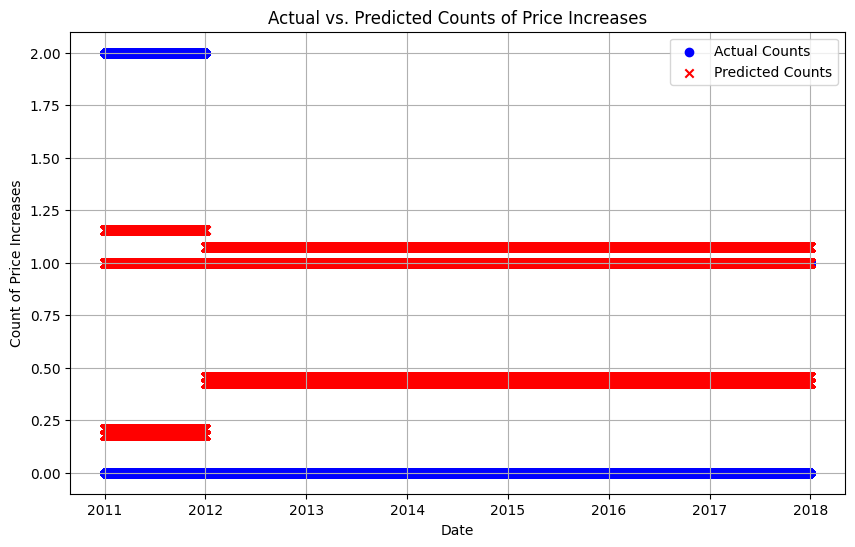

In [31]:
import matplotlib.pyplot as plt

# Plot actual counts vs. predicted counts using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(counts['Date'], counts['Price_Increase_Count'], label='Actual Counts', color='blue', marker='o')
plt.scatter(counts['Date'], predicted_counts, label='Predicted Counts', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Count of Price Increases')
plt.title('Actual vs. Predicted Counts of Price Increases')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


poisson_model_train = Poisson(y_train, X_train)
result_train = poisson_model_train.fit()

predicted_counts_test = result_train.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predicted_counts_test)
mse = mean_squared_error(y_test, predicted_counts_test)

print("Mean Absolute Error (MAE) on testing set:", mae)
print("Mean Squared Error (MSE) on testing set:", mse)


Optimization terminated successfully.
         Current function value: 0.864752
         Iterations 4
Mean Absolute Error (MAE) on testing set: 0.5559007998053755
Mean Squared Error (MSE) on testing set: 0.369027391968883


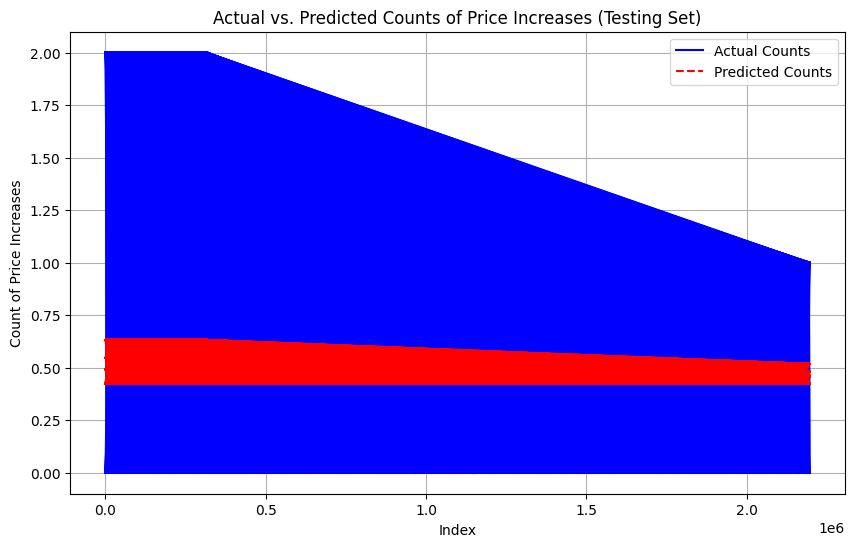

In [36]:
import matplotlib.pyplot as plt

# Set parameters to address the overflow error
plt.rcParams['agg.path.chunksize'] = 1000
plt.rcParams['path.simplify_threshold'] = 1.0

# Plot actual counts vs. predicted counts
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Counts', color='blue')
plt.plot(y_test.index, predicted_counts_test, label='Predicted Counts', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Count of Price Increases')
plt.title('Actual vs. Predicted Counts of Price Increases (Testing Set)')
plt.legend()
plt.grid(True)
plt.show()
